<a href="https://colab.research.google.com/github/Anielly-g/TCC/blob/main/testesIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ultralytics opencv-python
!pip install --upgrade torch torchvision torchaudio

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving imagem fila.jpg to imagem fila.jpg



image 1/1 /content/imagem fila.jpg: 416x640 7 persons, 1 dining table, 155.8ms
Speed: 3.6ms preprocess, 155.8ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)
Pessoas detectadas: 7
Tempo de execução: 0.43 segundos


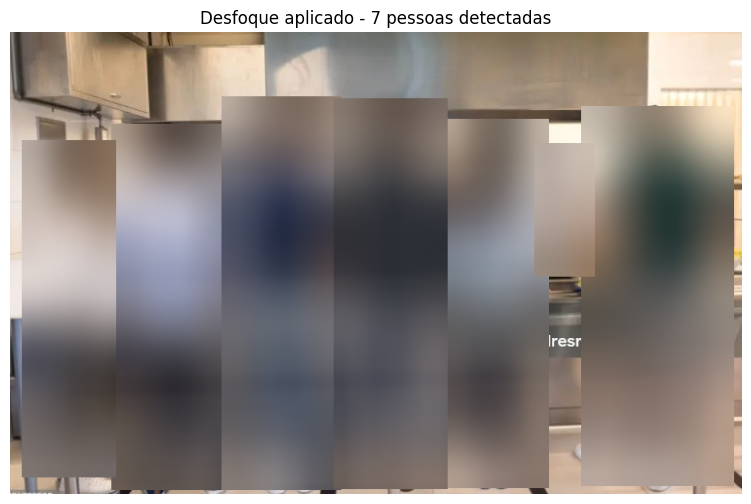

In [ ]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import os
import time

model = YOLO('yolov8n.pt')

img_path = list(uploaded.keys())[0]

image = cv2.imread(img_path)

start_time = time.time()

results = model(img_path)

persons = [det for det in results[0].boxes.data if int(det[-1]) == 0]
print(f"Pessoas detectadas: {len(persons)}")

for det in persons:
    x1, y1, x2, y2, conf, cls = det.cpu().numpy()
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    x1 = max(x1, 0)
    y1 = max(y1, 0)
    x2 = min(x2, image.shape[1])
    y2 = min(y2, image.shape[0])

    face_region = image[y1:y2, x1:x2]
    if face_region.size > 0:
        # Aplica desfoque gaussiano
        blurred_face = cv2.GaussianBlur(face_region, (99, 99), 30)
        image[y1:y2, x1:x2] = blurred_face

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo de execução: {elapsed_time:.2f} segundos")
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f'Desfoque aplicado - {len(persons)} pessoas detectadas')
plt.show()

Tempo de inferência (OpenCV + HOG): 2.13 segundos
Pessoas detectadas: 6


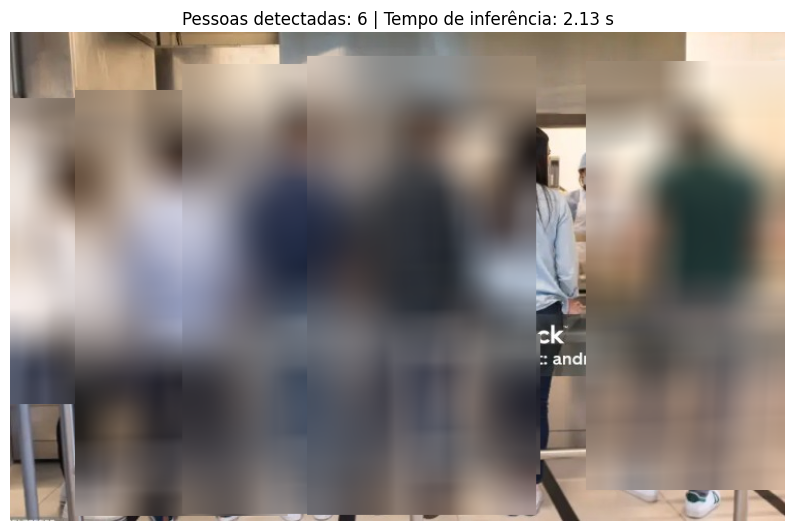

In [ ]:
import cv2
import time
from matplotlib import pyplot as plt

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

img_path = list(uploaded.keys())[0]
img = cv2.imread(img_path)

start_time = time.time()

(rects, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.05)

img_blur = img.copy()
for (x, y, w, h) in rects:
    region = img_blur[y:y+h, x:x+w]
    if region.size > 0:
        blurred = cv2.GaussianBlur(region, (51, 51), 30)
        img_blur[y:y+h, x:x+w] = blurred

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Tempo de inferência (OpenCV + HOG): {elapsed_time:.2f} segundos")
print(f"Pessoas detectadas: {len(rects)}")

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img_blur, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Pessoas detectadas: {len(rects)} | Tempo de inferência: {elapsed_time:.2f} s")
plt.show()

In [ ]:
from google.colab import files
uploaded = files.upload()
img_path = list(uploaded.keys())[0]


Saving imagem fila.jpg to imagem fila (1).jpg


Pessoas detectadas (MediaPipe Pose): 3
Tempo de inferência (MediaPipe): 0.48 segundos


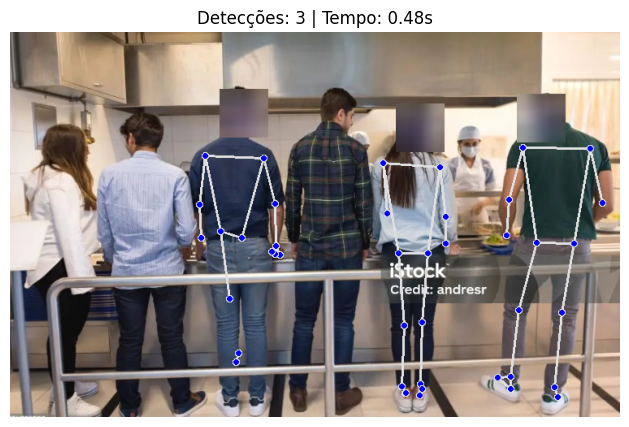

In [ ]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import time

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

image_bgr = cv2.imread(img_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
height, width = image_rgb.shape[:2]

step = width // 4
images = [image_rgb[:, i:i+step] for i in range(0, width, step)]

detected_count = 0
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

start_time = time.time()

for i, img_crop in enumerate(images):
    results = pose.process(img_crop)
    if results.pose_landmarks:
        detected_count += 1
        mp_drawing.draw_landmarks(img_crop, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        landmark_coords = results.pose_landmarks.landmark
        nose = landmark_coords[mp_pose.PoseLandmark.NOSE]
        left_eye = landmark_coords[mp_pose.PoseLandmark.LEFT_EYE]
        right_eye = landmark_coords[mp_pose.PoseLandmark.RIGHT_EYE]

        cx = int((left_eye.x + right_eye.x + nose.x) / 3 * img_crop.shape[1])
        cy = int((left_eye.y + right_eye.y + nose.y) / 3 * img_crop.shape[0])
        w = h = 60
        x1 = max(cx - w//2, 0)
        y1 = max(cy - h//2, 0)
        x2 = min(cx + w//2, img_crop.shape[1])
        y2 = min(cy + h//2, img_crop.shape[0])

        face_region = img_crop[y1:y2, x1:x2]
        if face_region.size > 0:
            blurred = cv2.GaussianBlur(face_region, (51, 51), 30)
            img_crop[y1:y2, x1:x2] = blurred

end_time = time.time()
elapsed_time = end_time - start_time

combined_img = np.hstack(images)

print(f"Pessoas detectadas (MediaPipe Pose): {detected_count}")
print(f"Tempo de inferência (MediaPipe): {elapsed_time:.2f} segundos")

plt.figure(figsize=(15, 5))
plt.imshow(combined_img)
plt.axis("off")
plt.title(f"Detecções: {detected_count} | Tempo: {elapsed_time:.2f}s")
plt.show()
